In [405]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import numpy as np
import seaborn as sn
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

In [406]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [407]:
def reduce_mem_usage(props):
    start_mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in props.columns:
        if props[col].dtype != object:  # Exclude strings
            
            # Print current column type
            print("******************************")
            print("Column: ",col)
            print("dtype before: ",props[col].dtype)
            
            # make variables for Int, max and min
            IsInt = False
            mx = props[col].max()
            mn = props[col].min()
            
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(props[col]).all(): 
                NAlist.append(col)
                props[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = props[col].fillna(0).astype(np.int64)
            result = (props[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True

            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        props[col] = props[col].astype(np.uint8)
                    elif mx < 65535:
                        props[col] = props[col].astype(np.uint16)
                    elif mx < 4294967295:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)    
            
            # Make float datatypes 32 bit
            else:
                props[col] = props[col].astype(np.float32)
            
            # Print new column type
            print("dtype after: ",props[col].dtype)
            print("******************************")
    
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return props, NAlist

In [408]:
props = pd.read_csv("/content/drive/MyDrive/Copy of train.csv", nrows=10000)

In [409]:
props, NAlist = reduce_mem_usage(props)
print("_________________")
print("")
print("Warning: the following columns have missing values filled with 'df['column_name'].min() -1': ")
print("_________________")
print("")
print(NAlist)

Memory usage of properties dataframe is : 0.381591796875  MB
******************************
Column:  unit_sales
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  onpromotion
dtype before:  float64
dtype after:  float64
******************************
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  0.34344482421875  MB
This is  90.00319897632758 % of the initial size
_________________

_________________

['onpromotion']


In [410]:
props = props.astype({'unit_sales':int})

In [411]:
props.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         10000 non-null  object 
 1   locationId   10000 non-null  object 
 2   item_id      10000 non-null  object 
 3   unit_sales   10000 non-null  int64  
 4   onpromotion  0 non-null      float64
dtypes: float64(1), int64(1), object(3)
memory usage: 390.8+ KB


In [412]:
props.rename(columns = {'locationId':'location_id'}, inplace = True)

In [413]:
location = pd.read_csv("/content/drive/MyDrive/location_details.csv")

In [414]:
df = pd.merge(props,location,on='location_id', how='left')

In [415]:
items = pd.read_csv("/content/drive/MyDrive/item_details.csv")

In [416]:
df_new = pd.merge(df,items,on='item_id', how='left')

In [417]:
df_new = df_new.astype({'unit_sales':int})

In [418]:
df_new

,date,location_id,item_id,unit_sales,onpromotion,city,state,type,cluster,category_of_item,class,perishable
0,2015-01-01,location_25,item_103665,7,NaN,Kanpur,Uttar Pradesh,D,1,baked_items / bread_based,class_2712,1
1,2015-01-01,location_25,item_105574,1,NaN,Kanpur,Uttar Pradesh,D,1,grocery_items,class_1045,0
2,2015-01-01,location_25,item_105575,2,NaN,Kanpur,Uttar Pradesh,D,1,grocery_items,class_1045,0
3,2015-01-01,location_25,item_108079,1,NaN,Kanpur,Uttar Pradesh,D,1,grocery_items,class_1030,0
4,2015-01-01,location_25,item_108701,1,NaN,Kanpur,Uttar Pradesh,D,1,deli_items,class_2644,1
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2015-01-02,location_9,item_698643,20,NaN,Bengaluru,Karnataka,B,6,grocery_items,class_1045,0
9996,2015-01-02,location_9,item_716241,5,NaN,Bengaluru,Karnataka,B,6,cleaning_utilities,class_3020,0
9997,2015-01-02,location_9,item_716242,12,NaN,Bengaluru,Karnataka,B,6,cleaning_utilities,class_3020,0
9998,2015-01-02,location_9,item_716245,7,NaN,Bengaluru,Karnataka,B,6,cleaning_utilities,class_3020,0


In [419]:
df_new[['item_id1', 'item_id2']] = df_new.item_id.str.split("_",expand=True,)

In [420]:
df_new[['location_id1', 'location_id2']] = df_new.location_id.str.split("_",expand=True,)

In [421]:
df_new

,date,location_id,item_id,unit_sales,onpromotion,city,state,type,cluster,category_of_item,class,perishable,item_id1,item_id2,location_id1,location_id2
0,2015-01-01,location_25,item_103665,7,NaN,Kanpur,Uttar Pradesh,D,1,baked_items / bread_based,class_2712,1,item,103665,location,25
1,2015-01-01,location_25,item_105574,1,NaN,Kanpur,Uttar Pradesh,D,1,grocery_items,class_1045,0,item,105574,location,25
2,2015-01-01,location_25,item_105575,2,NaN,Kanpur,Uttar Pradesh,D,1,grocery_items,class_1045,0,item,105575,location,25
3,2015-01-01,location_25,item_108079,1,NaN,Kanpur,Uttar Pradesh,D,1,grocery_items,class_1030,0,item,108079,location,25
4,2015-01-01,location_25,item_108701,1,NaN,Kanpur,Uttar Pradesh,D,1,deli_items,class_2644,1,item,108701,location,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2015-01-02,location_9,item_698643,20,NaN,Bengaluru,Karnataka,B,6,grocery_items,class_1045,0,item,698643,location,9
9996,2015-01-02,location_9,item_716241,5,NaN,Bengaluru,Karnataka,B,6,cleaning_utilities,class_3020,0,item,716241,location,9
9997,2015-01-02,location_9,item_716242,12,NaN,Bengaluru,Karnataka,B,6,cleaning_utilities,class_3020,0,item,716242,location,9
9998,2015-01-02,location_9,item_716245,7,NaN,Bengaluru,Karnataka,B,6,cleaning_utilities,class_3020,0,item,716245,location,9


In [422]:
train_data = df_new.drop(['item_id', 'item_id1','location_id','location_id1'], axis = 1)

In [423]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              10000 non-null  object 
 1   unit_sales        10000 non-null  int64  
 2   onpromotion       0 non-null      float64
 3   city              10000 non-null  object 
 4   state             10000 non-null  object 
 5   type              10000 non-null  object 
 6   cluster           10000 non-null  int64  
 7   category_of_item  10000 non-null  object 
 8   class             10000 non-null  object 
 9   perishable        10000 non-null  int64  
 10  item_id2          10000 non-null  object 
 11  location_id2      10000 non-null  object 
dtypes: float64(1), int64(3), object(8)
memory usage: 1015.6+ KB


In [424]:
categorical_features = ['onpromotion','city','state','type','category_of_item','class','perishable']

In [425]:
train_data[categorical_features]=train_data[categorical_features].astype('category')

In [426]:
train_data = train_data.astype({'item_id2':int, 'location_id2' : int})

In [427]:
train_data = train_data.drop(['city','state','class','perishable','onpromotion','type','category_of_item'],axis=1)

In [428]:
train_data

,date,unit_sales,cluster,item_id2,location_id2
0,2015-01-01,7,1,103665,25
1,2015-01-01,1,1,105574,25
2,2015-01-01,2,1,105575,25
3,2015-01-01,1,1,108079,25
4,2015-01-01,1,1,108701,25
...,...,...,...,...,...
9995,2015-01-02,20,6,698643,9
9996,2015-01-02,5,6,716241,9
9997,2015-01-02,12,6,716242,9
9998,2015-01-02,7,6,716245,9


In [429]:
reg_df = train_data

In [430]:
reg_df = reg_df.set_index('date')

In [431]:
reg_df = reg_df.astype({'unit_sales':int})

In [432]:
reg_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 2015-01-01 to 2015-01-02
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   unit_sales    10000 non-null  int64
 1   cluster       10000 non-null  int64
 2   item_id2      10000 non-null  int64
 3   location_id2  10000 non-null  int64
dtypes: int64(4)
memory usage: 390.6+ KB


In [433]:
for i in range(1,8):
    lag_i = 'lag_' + str(i)
    reg_df[lag_i] = reg_df.unit_sales.shift(i)
    
# Rolling window
reg_df['rolling_mean'] = reg_df.unit_sales.rolling(window=7).mean()
reg_df['rolling_max'] = reg_df.unit_sales.rolling(window=7).max()
reg_df['rolling_min'] = reg_df.unit_sales.rolling(window=7).min()

reg_df = reg_df.dropna(how='any', inplace=False)
#reg_df = reg_df.drop(['store', 'item'], axis=1)


reg_train_df = reg_df.iloc[:7000,:]
reg_test_df = reg_df.iloc[7001:,:]

#reg_df = reg_df.set_index('date')
#reg_train_df = reg_df.loc[:'2017-09-30']                        
#reg_test_df = reg_df.loc['2017-10-01':]

In [434]:
reg_train_df

,unit_sales,cluster,item_id2,location_id2,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean,rolling_max,rolling_min
date,,,,,,,,,,,,,,
2015-01-01,1,1,108952,25,1.0,3.0,1.0,1.0,2.0,1.0,7.0,1.428571,3.0,1.0
2015-01-01,13,1,111397,25,1.0,1.0,3.0,1.0,1.0,2.0,1.0,3.142857,13.0,1.0
2015-01-01,3,1,114790,25,13.0,1.0,1.0,3.0,1.0,1.0,2.0,3.285714,13.0,1.0
2015-01-01,1,1,114800,25,3.0,13.0,1.0,1.0,3.0,1.0,1.0,3.285714,13.0,1.0
2015-01-01,1,1,115267,25,1.0,3.0,13.0,1.0,1.0,3.0,1.0,3.285714,13.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-01-02,7,13,1045449,6,10.0,12.0,8.0,5.0,7.0,4.0,9.0,7.571429,12.0,4.0
2015-01-02,3,13,1046272,6,7.0,10.0,12.0,8.0,5.0,7.0,4.0,7.428571,12.0,3.0
2015-01-02,4,13,1047674,6,3.0,7.0,10.0,12.0,8.0,5.0,7.0,7.000000,12.0,3.0


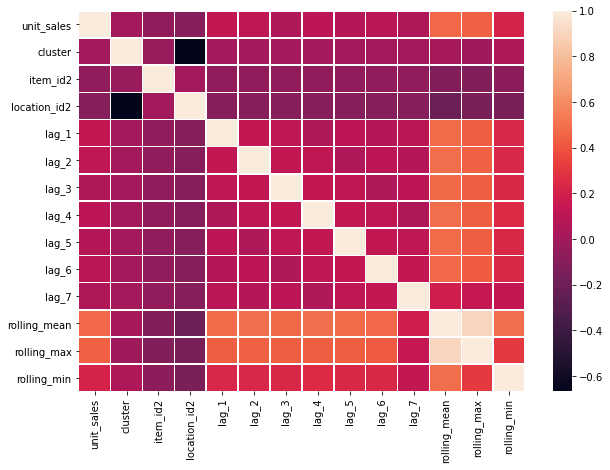

In [435]:
corr = reg_train_df.corr()
fig = plt.figure(figsize=(10,7))
_ = sn.heatmap(corr, linewidths=.5)

In [436]:
X_train = reg_train_df.drop(['unit_sales'], axis=1)
y_train = reg_train_df['unit_sales'].values

X_test = reg_test_df.drop(['unit_sales'], axis=1)
y_test = reg_test_df['unit_sales'].values

#Univariate SelectKBest class to extract top 5 best features
top_features = SelectKBest(score_func=f_regression, k=5)
fit = top_features.fit(X_train, y_train)
df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(X_train.columns)

#concat two dataframes for better visualization 
feature_scores = pd.concat([df_columns, df_scores], axis=1)
feature_scores.columns = ['Feature','Score']  # naming the dataframe columns
print(feature_scores.nlargest(5,'Score'))  # print 5 best features

         Feature        Score
10  rolling_mean  1987.395008
11   rolling_max  1714.953711
12   rolling_min   341.670232
3          lag_1   120.289955
4          lag_2    96.248633


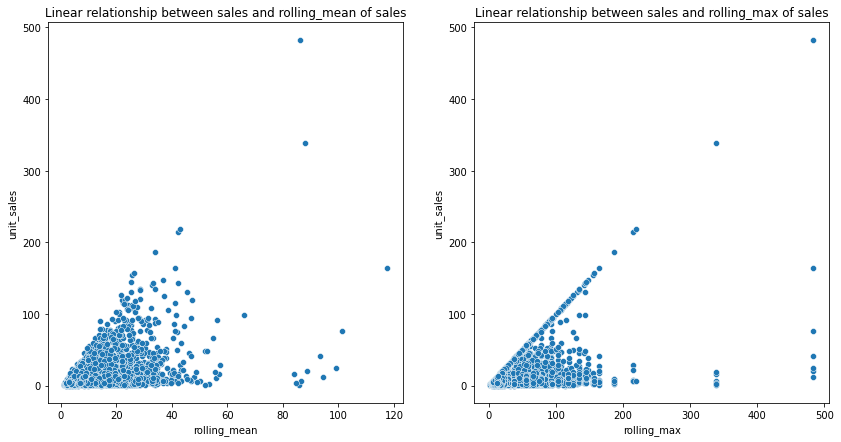

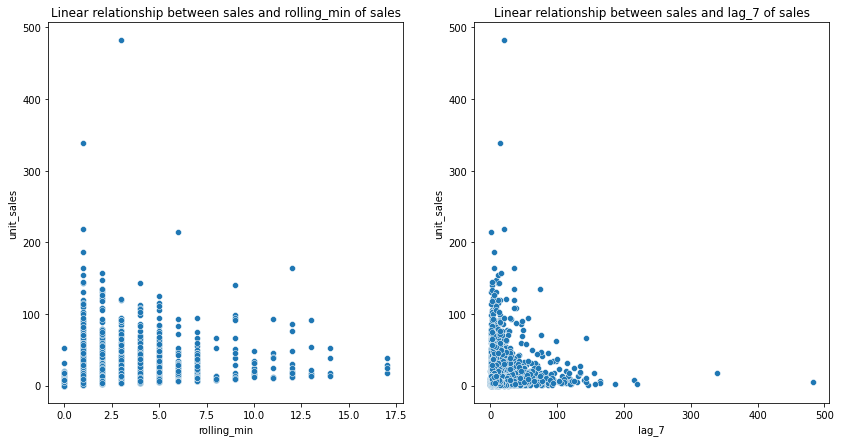

In [437]:
# Checking for a linear relationship of the top features with sales (target variable)
fig, axs = plt.subplots(ncols=2, figsize=(14,7))
sn.scatterplot(reg_train_df.rolling_mean, reg_train_df.unit_sales, ax=axs[0])
axs[0].set(title='Linear relationship between sales and rolling_mean of sales')
sn.scatterplot(reg_train_df.rolling_max, reg_train_df.unit_sales, ax=axs[1])
axs[1].set(title='Linear relationship between sales and rolling_max of sales')

fig, axs = plt.subplots(ncols=2, figsize=(14,7))
sn.scatterplot(reg_train_df.rolling_min, reg_train_df.unit_sales, ax=axs[0])
axs[0].set(title='Linear relationship between sales and rolling_min of sales')
sn.scatterplot(reg_train_df.lag_7, reg_train_df.unit_sales, ax=axs[1])
_ = axs[1].set(title='Linear relationship between sales and lag_7 of sales')

In [438]:
# update X_train, X_test to include top features
X_train = X_train[['rolling_mean', 'rolling_max', 'rolling_min', 'lag_7', 'lag_1']]
X_test = X_test[['rolling_mean', 'rolling_max', 'rolling_min', 'lag_7', 'lag_1']]

# fit model
model = LinearRegression()
model.fit(X_train, y_train)

preds = model.predict(X_test)

errors_df = reg_test_df[['unit_sales']]
errors_df['pred_sales'] = preds
errors_df['errors'] = preds - y_test
errors_df.insert(0, 'model', 'LinearRegression')

In [439]:
preds

array([10.2317318 , 14.42992585, 20.20052965, ..., 10.52456161,
        9.81922187, 11.72563204])

In [442]:
from sklearn.metrics import mean_absolute_error

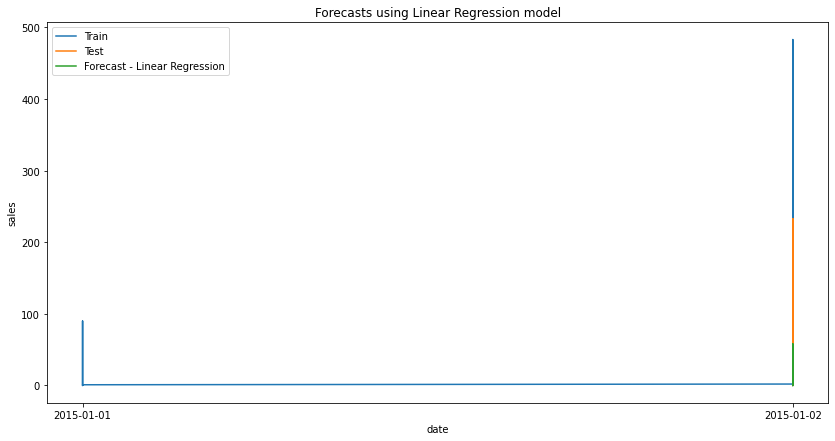

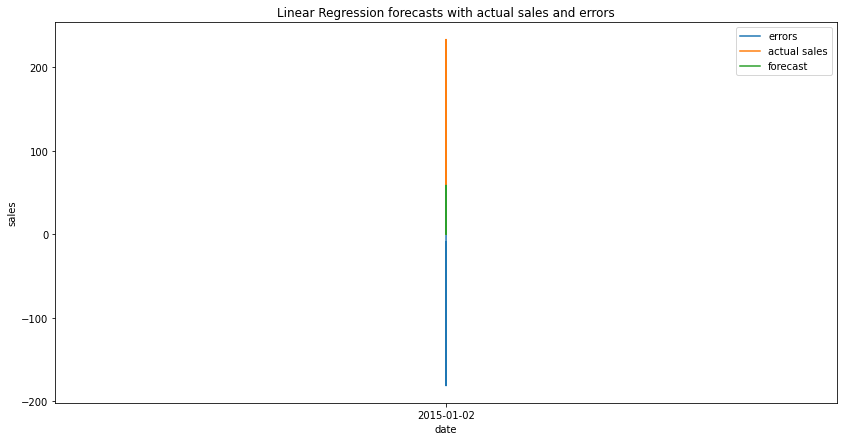

"result_df_lr = errors_df.groupby('model').agg(total_sales=('unit_sales', 'sum'),\n                                          total_pred_sales=('pred_sales', 'sum'),\n                                          LR_overall_error=('errors', 'sum'),\n                                          MAE=('errors', mae),\n                                          RMSE=('errors', rmse), \n                                          MAPE=('errors', mape))\nresult_df_lr"

In [444]:
# eval predictions
fig = plt.figure(figsize=(14,7))
plt.plot(reg_train_df.index, reg_train_df['unit_sales'], label='Train')
plt.plot(reg_test_df.index, reg_test_df['unit_sales'], label='Test')
plt.plot(errors_df.index, errors_df['pred_sales'], label='Forecast - Linear Regression')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Forecasts using Linear Regression model')
plt.show()

fig = plt.figure(figsize=(14,7))
plt.plot(errors_df.index, errors_df.errors, label='errors')
plt.plot(errors_df.index, errors_df.unit_sales, label='actual sales')
plt.plot(errors_df.index, errors_df.pred_sales, label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Linear Regression forecasts with actual sales and errors')
plt.show()

'''result_df_lr = errors_df.groupby('model').agg(total_sales=('unit_sales', 'sum'),
                                          total_pred_sales=('pred_sales', 'sum'),
                                          LR_overall_error=('errors', 'sum'),
                                          MAE=('errors', mae),
                                          RMSE=('errors', rmse), 
                                          MAPE=('errors', mape))
result_df_lr'''